### Figure S10

### Import packages

In [1]:
%load_ext nb_black

import scdiffeq as sdq
import cellplots as cp
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd
import numpy as np
import cell_perturb
import scipy.stats
import sklearn
import larry
import pathlib
import glob
import torch
import matplotlib.cm as cm
import statsmodels.stats.meta_analysis
from scipy.stats import combine_pvalues
import seaborn as sns

from typing import Union, Dict, List

cmap = larry.pl.InVitroColorMap()._dict

h5ad_path = (
    "/home/mvinyard/data/adata.reprocessed_19OCT2023.more_feature_inclusive.h5ad"
)
adata = sdq.io.read_h5ad(h5ad_path)

AnnData object with n_obs × n_vars = 130887 × 2492
    obs: 'Library', 'Cell barcode', 'Time point', 'Starting population', 'Cell type annotation', 'Well', 'SPRING-x', 'SPRING-y', 'clone_idx', 'fate_observed', 't0_fated', 'train'
    var: 'gene_ids', 'hv_gene', 'must_include', 'exclude', 'use_genes'
    uns: 'fate_counts', 'h5ad_path', 'time_occupance'
    obsm: 'X_clone', 'X_pca', 'X_umap', 'cell_fate_df'
    layers: 'X_scaled'


<IPython.core.display.Javascript object>

In [2]:
def aggr_fate_statistics(results, fate):
    _aggr_fate_frames = []
    for version, frame in results.items():
        fate_version_frame = (
            frame["lfc"][fate]
            .to_frame()
            .reset_index()
            .rename({"index": "gene", fate: "lfc"}, axis=1)
        )
        fate_version_frame["model"] = version
        fate_version_frame["pval"] = frame["pval"][fate].values
        fate_version_frame["se"] = (
            frame["lfc_std"][fate].div(np.sqrt(frame["lfc_std"]["n"])).values
        )
        _aggr_fate_frames.append(fate_version_frame)

    return pd.concat(_aggr_fate_frames)


def adjust_negative_i2(meta_results_df):
    i2 = np.zeros(len(meta_results_df))
    mask = meta_results_df["i2"] > 0
    pos_i2 = meta_results_df.loc[mask]["i2"].values
    i2[mask] = pos_i2
    meta_results_df["i2"] = i2


def run_meta_analysis(aggr_stats):
    meta_analysis_results = []
    for gene in aggr_stats["gene"].unique():
        gene_df = aggr_stats.loc[aggr_stats["gene"] == gene]
        effect = gene_df["lfc"].values
        variance = (gene_df["se"] ** 2).values
        res_re = statsmodels.stats.meta_analysis.combine_effects(
            effect=effect, variance=variance, method_re="iterated"
        )
        conf_int = np.array(res_re.conf_int())
        ci_low, ci_high = conf_int[:, 0], conf_int[:, 1]

        meta_analysis_results.append(
            {
                "gene": gene,
                "pooled_mean_lfc_re": res_re.mean_effect_re,
                "ci_low": ci_low[0],  # Accessing the first element for CI
                "ci_high": ci_high[0],  # Accessing the first element for CI
                "i2": res_re.i2,
                "q": res_re.q,
            }
        )

    meta_results_df = pd.DataFrame(meta_analysis_results).set_index("gene")
    adjust_negative_i2(meta_results_df)

    return meta_results_df


def combine_expand(pvals):
    stat, combined_pval = combine_pvalues(pvals, method="fisher")
    return {"stat": stat, "combined_pval": combined_pval}


def prepare_stat_df_for_plotting(stats):

    stats["x"] = stats["pooled_mean_lfc_re"]
    stats["y"] = stats["combined_pval"].apply(np.log10) * -1
    stats["significant"] = stats["combined_pval"] < 0.05
    stats["insignificant"] = stats["combined_pval"] >= 0.05
    stats["pos"] = stats["pooled_mean_lfc_re"] > 0
    stats["neg"] = stats["pooled_mean_lfc_re"] <= 0

    stats["sig.pos"] = stats["significant"] & stats["pos"]
    stats["sig.neg"] = stats["significant"] & stats["neg"]
    stats["insig.pos"] = stats["insignificant"] & stats["pos"]
    stats["insig.neg"] = stats["insignificant"] & stats["neg"]

    assert not any(stats[["sig.pos", "sig.neg", "insig.pos", "insig.neg"]].sum(1) > 1)
    stats["group"] = stats[["sig.pos", "sig.neg", "insig.pos", "insig.neg"]].idxmax(1)

    return stats


def plot(stats, xlim=(None, None), ylim=(-2, None)):
    fig, axes = cp.plot(
        1,
        1,
        height=0.5,
        width=0.5,
        delete=[["top", "right"]],
        title=[
            ""
        ],  # LARRY Neutrophil Fate Perturbation Screen (N=5, z=10)"],  # Meta (5 models):
    )
    for group, group_df in stats.groupby("group"):
        if "insig" in group:
            c = "lightgrey"
        elif "pos" in group:
            c = "crimson"
        elif "neg" in group:
            c = "navy"
        axes[0].scatter(
            group_df["x"],
            group_df["y"],
            s=5,
            ec="None",
            c=c,
            rasterized=True,
            alpha=0.2,
        )
    axes[0].grid(True, alpha=0.2)
    axes[0].set_xlim(xlim)
    axes[0].set_ylim(ylim)
    neg_highlight = stats[stats["sig.neg"]].sort_values("y").tail(15)
    for i, row in neg_highlight.iterrows():
        axes[0].scatter(row["x"], row["y"], s=15, c="navy", ec="None", rasterized=True)
        axes[0].text(
            x=row["x"] * 1.1,
            y=row["y"] * 1.02,
            s=row.name,
            color="navy",
            ha="right",
            fontsize=6,
        )

    neg_highlight = stats[stats["sig.pos"]].sort_values("y").tail(15)
    for i, row in neg_highlight.iterrows():
        axes[0].scatter(
            row["x"], row["y"], s=15, c="crimson", ec="None", rasterized=True
        )
        axes[0].text(
            x=row["x"] * 1.1, y=row["y"] * 1.02, s=row.name, color="crimson", fontsize=6
        )
    axes[0].hlines(y=-np.log10(0.05), xmin=-2, xmax=2, color="k", ls="--", lw=1)

    # plt.savefig("LARRY.neu_screen.meta_analysis.svg", dpi=500)

<IPython.core.display.Javascript object>

In [3]:
import ABCParse


class RawScreenProcessor(ABCParse.ABCParse):
    """Processed pkl to .csv"""

    def __init__(self, results_dir: Union[pathlib.Path, str], *args, **kwargs):
        self.__parse__(locals())

        self._initialize_directory_structure()

    @property
    def results_dir(self):
        return pathlib.Path(self._results_dir)

    @property
    def pkl_dir(self):
        return self.results_dir.joinpath("pkl")

    @property
    def csv_dir(self):
        return self.results_dir.joinpath("csv")

    def _initialize_directory_structure(self):
        """/pkl/ subdir should already exist, so we shouldn't create it here."""
        if not self.csv_dir.exists():
            self.csv_dir.mkdir()

    @property
    def _discovered_csv_paths(self):
        return sorted(list(self.csv_dir.glob("*.csv")))

    @property
    def pkl_paths(self):
        return sorted(list(self.pkl_dir.glob("*.pkl")))

    def _process_attribute(self, file, key):
        return (
            pd.DataFrame({gene: result.stats[key] for gene, result in file.items()})
            .fillna(0)
            .T
        )

    def _get_n(self, file, gene):
        return np.unique([file[gene].ctrl.shape[1], file[gene].prtb.shape[1]])[0]

    def _read_and_process_raw_pkl_files(self):
        ScreenResults = {}
        attr_cols = ["lfc", "lfc_std", "pval"]
        for pkl_path in self.pkl_paths:
            version = pkl_path.name.split("version_")[-1].split(".")[0]
            version = f"version_{version}"
            if not version in ScreenResults:
                ScreenResults[version] = {}
            csv_paths = {
                attr: self.csv_dir.joinpath(f"{version}.{attr}.csv")
                for attr in attr_cols
            }
            exists = [csv_path.exists() for csv_path in list(csv_paths.values())]
            if not all(exists):
                file = sdq.io.read_pickle(pkl_path)
                for attr, csv_path in csv_paths.items():

                    df = self._process_attribute(file, attr)
                    if attr == "lfc_std":
                        n = [self._get_n(file, gene) for gene in file.keys()]
                        df["n"] = n
                    df.to_csv(csv_path)
                    ScreenResults[version][attr] = df
            else:
                for attr, csv_path in csv_paths.items():
                    ScreenResults[version][attr] = pd.read_csv(csv_path, index_col=0)

        return ScreenResults

    def __call__(self, *args, **kwargs):
        self.__update__(locals())

        return self._read_and_process_raw_pkl_files()


def process_raw_results(results_dir: str = "./larry_perturbation_screen_results/"):
    raw_screen_processor = RawScreenProcessor(results_dir=results_dir)
    return raw_screen_processor()

<IPython.core.display.Javascript object>

In [4]:
def aggr_fate_statistics(results, fate):
    _aggr_fate_frames = []
    for version, frame in results.items():
        fate_version_frame = (
            frame["lfc"][fate]
            .to_frame()
            .reset_index()
            .rename({"index": "gene", fate: "lfc"}, axis=1)
        )
        fate_version_frame["model"] = version
        fate_version_frame["pval"] = frame["pval"][fate].values
        fate_version_frame["se"] = (
            frame["lfc_std"][fate].div(np.sqrt(frame["lfc_std"]["n"])).values
        )
        _aggr_fate_frames.append(fate_version_frame)

    return pd.concat(_aggr_fate_frames)


def adjust_negative_i2(meta_results_df):
    i2 = np.zeros(len(meta_results_df))
    mask = meta_results_df["i2"] > 0
    pos_i2 = meta_results_df.loc[mask]["i2"].values
    i2[mask] = pos_i2
    meta_results_df["i2"] = i2


def run_meta_analysis(aggr_stats):
    meta_analysis_results = []
    for gene in aggr_stats["gene"].unique():
        gene_df = aggr_stats.loc[aggr_stats["gene"] == gene]
        effect = gene_df["lfc"].values
        variance = (gene_df["se"] ** 2).values
        res_re = statsmodels.stats.meta_analysis.combine_effects(
            effect=effect, variance=variance, method_re="iterated"
        )
        conf_int = np.array(res_re.conf_int())
        ci_low, ci_high = conf_int[:, 0], conf_int[:, 1]

        meta_analysis_results.append(
            {
                "gene": gene,
                "pooled_mean_lfc_re": res_re.mean_effect_re,
                "ci_low": ci_low[0],  # Accessing the first element for CI
                "ci_high": ci_high[0],  # Accessing the first element for CI
                "i2": res_re.i2,
                "q": res_re.q,
            }
        )

    meta_results_df = pd.DataFrame(meta_analysis_results).set_index("gene")
    adjust_negative_i2(meta_results_df)

    return meta_results_df


def combine_expand(pvals):
    stat, combined_pval = combine_pvalues(pvals, method="fisher")
    return {"stat": stat, "combined_pval": combined_pval}


def prepare_stat_df_for_plotting(stats):

    stats["x"] = stats["pooled_mean_lfc_re"]
    stats["y"] = stats["combined_pval"].apply(np.log10) * -1
    stats["significant"] = stats["combined_pval"] < 0.05
    stats["insignificant"] = stats["combined_pval"] >= 0.05
    stats["pos"] = stats["pooled_mean_lfc_re"] > 0
    stats["neg"] = stats["pooled_mean_lfc_re"] <= 0

    stats["sig.pos"] = stats["significant"] & stats["pos"]
    stats["sig.neg"] = stats["significant"] & stats["neg"]
    stats["insig.pos"] = stats["insignificant"] & stats["pos"]
    stats["insig.neg"] = stats["insignificant"] & stats["neg"]

    assert not any(stats[["sig.pos", "sig.neg", "insig.pos", "insig.neg"]].sum(1) > 1)
    stats["group"] = stats[["sig.pos", "sig.neg", "insig.pos", "insig.neg"]].idxmax(1)

    return stats


def plot_volcano(
    stats, xlim=(None, None), ylim=(-2, None), savepath=None, highlight_genes=[]
):
    fig, axes = cp.plot(
        1,
        1,
        height=0.5,
        width=0.5,
        delete=[["top", "right"]],
        title=[
            ""
        ],  # LARRY Neutrophil Fate Perturbation Screen (N=5, z=10)"],  # Meta (5 models):
    )
    for group, group_df in stats.groupby("group"):
        if "insig" in group:
            c = "lightgrey"
        elif "pos" in group:
            c = "crimson"
        elif "neg" in group:
            c = "navy"
        axes[0].scatter(
            group_df["x"],
            group_df["y"],
            s=5,
            ec="None",
            c=c,
            rasterized=True,
            alpha=0.2,
        )
    axes[0].grid(True, alpha=0.2)
    axes[0].set_xlim(xlim)
    axes[0].set_ylim(ylim)

    stats_highlight = stats.loc[highlight_genes].copy()

    neg_highlight = stats_highlight[stats_highlight["sig.neg"]]
    for i, row in neg_highlight.iterrows():
        axes[0].scatter(row["x"], row["y"], s=15, c="navy", ec="None", rasterized=True)
        axes[0].text(
            x=row["x"] * 1.1,
            y=row["y"] * 1.02,
            s=row.name,
            color="navy",
            ha="right",
            fontsize=6,
        )

    pos_highlight = stats_highlight[stats_highlight["sig.pos"]]
    for i, row in pos_highlight.iterrows():
        axes[0].scatter(
            row["x"], row["y"], s=15, c="crimson", ec="None", rasterized=True
        )
        axes[0].text(
            x=row["x"] * 1.1, y=row["y"] * 1.02, s=row.name, color="crimson", fontsize=6
        )
    axes[0].hlines(y=-np.log10(0.05), xmin=-2, xmax=2, color="k", ls="--", lw=1)

    if savepath:
        plt.savefig(savepath, dpi=500)

<IPython.core.display.Javascript object>

In [5]:
import ABCParse


class MetaAnalysis(ABCParse.ABCParse):
    def __init__(
        self, results_dir: str = "./larry_perturbation_screen_results", *args, **kwargs
    ):
        self.__parse__(locals())

        self.results = process_raw_results(self.results_dir)

    @property
    def results_dir(self):
        results_dir = pathlib.Path(self._results_dir)
        if not results_dir.exists():
            results_dir.mkdir()
        return results_dir

    def _combine_pvals(self, aggr):
        return aggr.groupby("gene")["pval"].apply(combine_expand).unstack()

    @property
    def aggr(self):
        if not hasattr(self, "_attr"):
            self._attr = aggr_fate_statistics(self.results, fate=self._fate)
        return self._attr

    def forward(self, fate):

        self._fate = fate

        meta = run_meta_analysis(self.aggr)
        combined_pvals = self._combine_pvals(self.aggr)
        stats = pd.concat(
            [
                meta["pooled_mean_lfc_re"],
                combined_pvals["combined_pval"],
            ],
            axis=1,
        )
        return prepare_stat_df_for_plotting(stats)

<IPython.core.display.Javascript object>

In [6]:
neu_meta_analysis = MetaAnalysis()
neu_stats = neu_meta_analysis.forward("Neutrophil")
neu_aggr = neu_meta_analysis.aggr

<IPython.core.display.Javascript object>

In [7]:
mon_meta_analysis = MetaAnalysis()
mon_stats = mon_meta_analysis.forward("Monocyte")
mon_aggr = mon_meta_analysis.aggr

<IPython.core.display.Javascript object>

In [8]:
baso_meta_analysis = MetaAnalysis()
baso_stats = baso_meta_analysis.forward("Baso")
baso_aggr = baso_meta_analysis.aggr

<IPython.core.display.Javascript object>

In [9]:
HighlightGenes = {
    "Neutrophil": [
        "Il6st",
        "Socs3",
        "Ccr2",
        "Elane",
        "Mpo",
        "Prtn3",
        "Ctsg",
        "Gfi1",
        "S100a8",
        "S100a9",
        "Cd33",
        "Itgam",
        "Cebpe",
        "Lipg",
        "Tfrc",
        "Gpx4",
        "Cd47",
        "Lcn2",
        "Itgb2",
        "Ncf1",
        "Cebpd",
        "Mcl1",
    ],
    "Monocyte": [
        "Csf1r",
        "Ccl3",
        "Klf4",
        "Socs3",
        "Vim",
        "Ccr2",
        "Gata2",
        "Il6st",
        "Cebpa",
        "Tgfbi",
        "Il6",
        "Fpr1",
        "Gfi1",
        "Cxcr2",
        "Cd47",
        "Igf1r",
        "Hgf",
        "Lpl",
    ],
    "Baso": [
        "Csf2rb",
        "Csf2rb2",
        "Il4",
        "Csf1",
        "Il6",
        "Gata2",
        "Cpa3",
        "Fcer1g",
        "Hdc",
        "Il18rap",
        "Il6st",
        "Tgfbi",
        "Alox5",
    ],
}

<IPython.core.display.Javascript object>

In [10]:
def unanimously_significant_genes(aggr):
    """returns lfc for unanimously significant genes."""
    unanimous = {}
    for gene, gene_df in aggr.groupby("gene"):
        if all(gene_df["pval"] < 0.05):
            unanimous[gene] = gene_df["lfc"].values
    return pd.DataFrame(unanimous).T

<IPython.core.display.Javascript object>

In [11]:
unan_neu = unanimously_significant_genes(neu_aggr)
unan_mon = unanimously_significant_genes(mon_aggr)
unan_baso = unanimously_significant_genes(baso_aggr)

<IPython.core.display.Javascript object>

In [12]:
def get_highlighted_yticklabels(heatmap_idx, highlight_genes: list):
    ytick_labels = []
    for label in heatmap_idx:
        if label in highlight_genes:
            ytick_labels.append(label)
        else:
            ytick_labels.append("")

    return ytick_labels

<IPython.core.display.Javascript object>

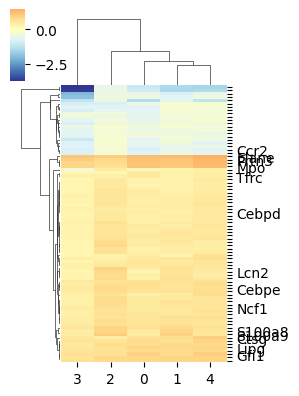

<IPython.core.display.Javascript object>

In [13]:
ytick_labels = get_highlighted_yticklabels(
    unan_neu.index, highlight_genes=HighlightGenes["Neutrophil"]
)

cg = sns.clustermap(
    unan_neu,
    figsize=(3, 4),
    cmap=cm.RdYlBu_r,
    center=0,
    yticklabels=ytick_labels,
)
plt.savefig("clustermap.LARRY.five_seeds.lfc_neutrophil.svg")

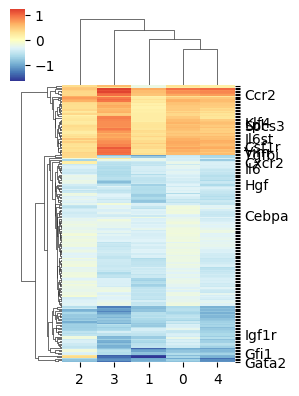

<IPython.core.display.Javascript object>

In [14]:
ytick_labels = get_highlighted_yticklabels(
    unan_mon.index, highlight_genes=HighlightGenes["Monocyte"]
)

cg = sns.clustermap(
    unan_mon,
    figsize=(3, 4),
    cmap=cm.RdYlBu_r,
    center=0,
    yticklabels=ytick_labels,
)
plt.savefig("clustermap.LARRY.five_seeds.lfc_monocyte.svg")

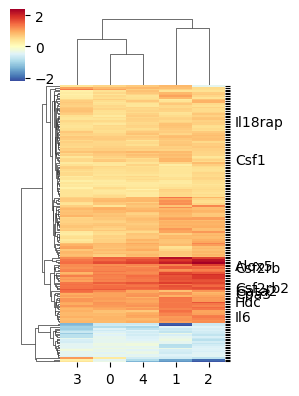

<IPython.core.display.Javascript object>

In [15]:
ytick_labels = get_highlighted_yticklabels(
    unan_baso.index, highlight_genes=HighlightGenes["Baso"]
)

cg = sns.clustermap(
    unan_baso,
    figsize=(3, 4),
    cmap=cm.RdYlBu_r,
    center=0,
    yticklabels=ytick_labels,
)
plt.savefig("clustermap.LARRY.five_seeds.lfc_baso.svg")